#1

In [253]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras


# Parameters
L = 2.0             # Length of the beam [m]
EI = 2e6            # Flexural rigidity [Nm^2]
Q = 1e3 # Uniform load [N/m]
P = 1e3         # Point load [N]
a = L / 2            # Load applied at midspan
hinge_loc = L / 2.

colloc_width = L / 4.
colloc_density = 20

dl = 0.005 * L
dl_norm = tf.cast(dl / L, dtype = tf.float32)

act = 'swish'
Noise = True
USE_COLLOC = False


In [254]:
x_full = np.linspace(0, L, 200)
x_full_norm = x_full/ L

def w(x, L, Q):
 w = (Q * x**2 * (6*L**2 - 4*L*x + x**2)) / (24 * EI)
 return w

def w_point_load(x, P, a):
    w = np.zeros_like(x)
    mask1 = x <= a
    mask2 = x > a
    w[mask1] = (P * x[mask1]**2 * (3*a - x[mask1])) / (6 * EI)
    w[mask2] = (P * a**2 * (3*x[mask2] - a)) / (6 * EI)
    return w

def w_pl_smooth_tf(x, P, a, k=200.0):
    H = tf.sigmoid(k*(a - x))           # ~ 1 for x<a, ~0 for x>a
    left  = (x**2 * (3*a - x)) / (6 * EI)
    right = (a**2 * (3*x - a)) / (6 * EI)
    return tf.cast((H*left + (1.0 - H)*right), dtype=tf.float32) * P

def get_collocation_points(x_sensors, pred_hinge_loc, colloc_width, colloc_density):

    hinge_start = pred_hinge_loc - colloc_width / 2.
    hinge_end = pred_hinge_loc + colloc_width / 2.
    
    dense_sensors = tf.linspace(hinge_start, hinge_end, colloc_density)
    dense_sensors = tf.cast(tf.reshape(dense_sensors, (-1, 1)), dtype=tf.float32)
    x_colloc = tf.concat((x_sensors, dense_sensors), axis=0)
    
    return tf.sort(x_colloc, axis=0)

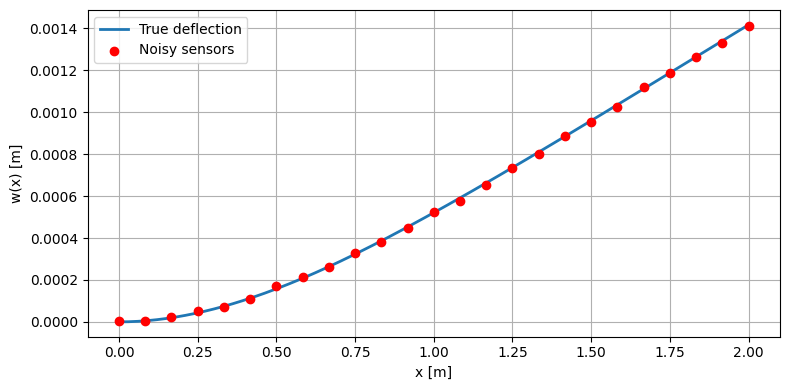

In [255]:
x_full = np.linspace(0, L, 200)

w_true = w(x_full, L, Q) + w_point_load(x_full, P, a)
#w_true = w(x_full, L, Q)

x_sensors = np.linspace(0, L, 25)
w_sensors_clean = w(x_sensors, L, Q) + w_point_load(x_sensors, P, a)
#w_sensors_clean = w(x_sensors, L, Q)
w_sensors = w_sensors_clean

if Noise:
  np.random.seed(42)
  noise_std = 0.005 * np.max(w_sensors_clean)
  noise = np.random.normal(0, noise_std, size=w_sensors_clean.shape)
  w_sensors += noise

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x_full, w_true, label="True deflection", linewidth=2)
plt.scatter(x_sensors, w_sensors, color='red', label="Noisy sensors", zorder=3)
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

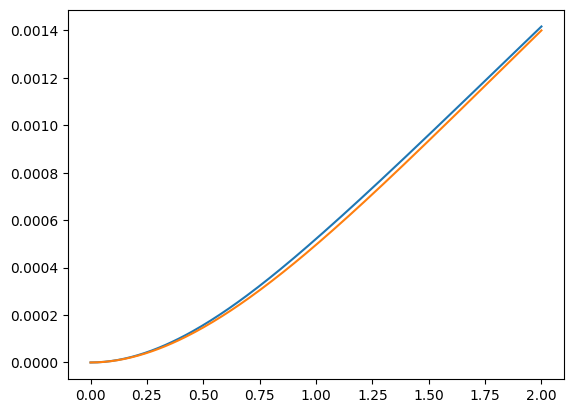

In [256]:
#plt.plot(x_full, w_pl_smooth_tf(x_full, P, a))
plt.plot(x_full, w_true)
plt.plot(x_full, w(x_full, L, 1.4 * Q))

#2

In [257]:
x_sensors_norm = (x_sensors / L).reshape(-1, 1)
w_max = w_sensors_clean.max()  # still use clean max for scaling
w_sensors_norm = (w_sensors / w_max).reshape(-1, 1)

x_tf = tf.convert_to_tensor(x_full_norm, dtype=tf.float32)
x_sensors_tf = tf.convert_to_tensor(x_sensors_norm, dtype=tf.float32)
w_sensors_tf = tf.convert_to_tensor(w_sensors_norm.reshape(-1, 1), dtype=tf.float32)

q_hat_norm = tf.Variable(0.0, dtype=tf.float32)
q_pl_norm = tf.Variable(0.0, dtype=tf.float32)

In [258]:
model = keras.models.Sequential([
        keras.layers.Input(shape=(1,)),
        keras.layers.Dense(64, activation = act, dtype = tf.float32),
        keras.layers.Dense(64, activation = act, dtype = tf.float32),
        keras.layers.Dense(1,)  #two outputs: deflection and discontinuity
    ])

optimizer = keras.optimizers.Adam(learning_rate = 1e-3)
optimizer_f = keras.optimizers.Adam(learning_rate = 1e-3)
optimizer_q = keras.optimizers.Adam(learning_rate = 1e-3)

In [259]:
@tf.function
def compute_derivatives(x_input):        #continuous derivatives for boundary conditions
    with tf.GradientTape() as tape4:
        tape4.watch(x_input)
        with tf.GradientTape() as tape3:
            tape3.watch(x_input)
            with tf.GradientTape() as tape2:
                tape2.watch(x_input)
                with tf.GradientTape() as tape1:
                    tape1.watch(x_input)
                    w_hat = model(x_input)
                dw = tape1.gradient(w_hat, x_input)
            d2w = tape2.gradient(dw, x_input)
        d3w = tape3.gradient(d2w, x_input)
    d4w = tape4.gradient(d3w, x_input)
    return w_hat, dw, d2w, d3w, d4w

compute_derivatives_bc = compute_derivatives


In [260]:
beta = tf.constant(0.9, dtype=tf.float32)  # Smoothing factor

w_data = tf.Variable(1.0, dtype=tf.float32)
w_phys = tf.Variable(0.5, dtype=tf.float32)
w_bc = tf.Variable(1.0, dtype=tf.float32)

w_filter = tf.Variable(0.1, dtype=tf.float32)
w_spikes = tf.Variable(0.1, dtype=tf.float32)

w_all = tf.Variable(1.0, dtype=tf.float32)



In [261]:
def get_w_pred(x_sensors_tf):
    x_sensors_phys = x_sensors_tf * L
    w_pred_integrate = w_pl_smooth_tf(x_sensors_phys, q_pl_norm * P, a) / w_max
    w_pred_smooth = model(x_sensors_tf)
    return w_pred_integrate + w_pred_smooth


In [262]:
@tf.function
def train_step():
    with tf.GradientTape(persistent=True) as tape:
        
        w_pred = get_w_pred(x_sensors_tf)
        data_loss = tf.reduce_mean(tf.square(w_pred - w_sensors_tf))

        w0, dw0, *_ = compute_derivatives_bc(tf.convert_to_tensor([0.0], dtype=tf.float32))
        *_, dwl2, dwl3, _ = compute_derivatives_bc(tf.convert_to_tensor([1.0], dtype=tf.float32))
        bc_loss = tf.reduce_mean(w0**2 + dw0**2 + dwl2**2 + dwl3**2)
        
        *_, d4w_norm = compute_derivatives(x_sensors_tf)
        q_hat_tf = tf.ones_like(d4w_norm) * q_hat_norm
        physics_residual = d4w_norm * (EI * w_max / (L**4 * Q)) - q_hat_tf
        physics_loss = tf.reduce_mean(tf.square(physics_residual))
        
        w_data.assign(1.0)
        w_bc.assign(0.1)
        w_phys.assign(0.1)
        
        differentiable_loss = w_data * data_loss + w_bc * bc_loss + w_phys * physics_loss

    variables = model.trainable_variables + [q_hat_norm, q_pl_norm]
    grads = tape.gradient(differentiable_loss, variables)
    optimizer.apply_gradients(zip(grads, variables))

    total_loss = sum([data_loss, bc_loss, physics_loss])
    return total_loss, data_loss, bc_loss, physics_loss

In [263]:
Data_only = False

N_DATA = 10000
N_FILTER = 20000
N_SMTH = 50000
N_INTERM = 20000
N_INTEGRATE = 40000

N_TOTAL = 20000
history = {"loss": [], "data": [], "phys": [], "bc": [], "filter": [], "q_hat_norm": [], "q_pl_norm":[]}
history_weights = {"w_data": [], "w_phys": [], "w_bc": [], "w_filter": [], "w_spikes": []}

In [ ]:
for epoch in range(N_TOTAL):

    loss, data_l, bc_l, phys_l = train_step()
    filter_l = tf.constant(0.0, dtype=tf.float32)
    
    if epoch % 1000 == 0:
        print(f"Epoch {epoch:5d} | Total: {loss.numpy().item():.6f} | "f"Data: {data_l.numpy().item():.6f} | Phys: {phys_l.numpy().item():.6f} | BC: {bc_l.numpy().item():.6f}| udl q: {q_hat_norm.numpy()}| pl q: {q_pl_norm.numpy()}")
    history["loss"].append(loss.numpy().item())
    history["data"].append(data_l.numpy().item())
    history["phys"].append(phys_l.numpy().item())
    history["bc"].append(bc_l.numpy().item())
    history["q_hat_norm"].append(q_hat_norm.numpy().item())
    history["q_pl_norm"].append(q_pl_norm.numpy().item())

Epoch     0 | Total: 0.286664 | Data: 0.286113 | Phys: 0.000000 | BC: 0.000551| udl q: -0.0009367188904434443| pl q: 0.000999974668957293
Epoch  1000 | Total: 0.091738 | Data: 0.003320 | Phys: 0.036442 | BC: 0.051975| udl q: 0.5764409899711609| pl q: 0.6126710176467896
Epoch  2000 | Total: 0.000138 | Data: 0.000017 | Phys: 0.000112 | BC: 0.000009| udl q: 1.1148710250854492| pl q: 0.7027611136436462
Epoch  3000 | Total: 0.000037 | Data: 0.000017 | Phys: 0.000011 | BC: 0.000009| udl q: 1.1163431406021118| pl q: 0.7038431167602539
Epoch  4000 | Total: 0.000026 | Data: 0.000017 | Phys: 0.000001 | BC: 0.000008| udl q: 1.116517424583435| pl q: 0.7043730616569519
Epoch  5000 | Total: 0.000025 | Data: 0.000017 | Phys: 0.000001 | BC: 0.000007| udl q: 1.1162811517715454| pl q: 0.705051064491272
Epoch  6000 | Total: 0.000025 | Data: 0.000017 | Phys: 0.000001 | BC: 0.000007| udl q: 1.1158781051635742| pl q: 0.7061479091644287
Epoch  7000 | Total: 0.000025 | Data: 0.000017 | Phys: 0.000001 | BC: 0.

In [265]:
_, dw, d2w, d3w, d4w = compute_derivatives_bc(x_tf)
dw, *_, d4w = compute_derivatives(x_tf)

x_tf = tf.reshape(x_tf, (-1,1))
b_pred = tf.ones_like(x_tf)
w_pred = get_w_pred(x_tf) * w_max
q_dim = q_hat_norm.numpy()
q_pred = q_dim.flatten()
q_pred = q_pred * Q


R² score (PINN Model): 0.99994


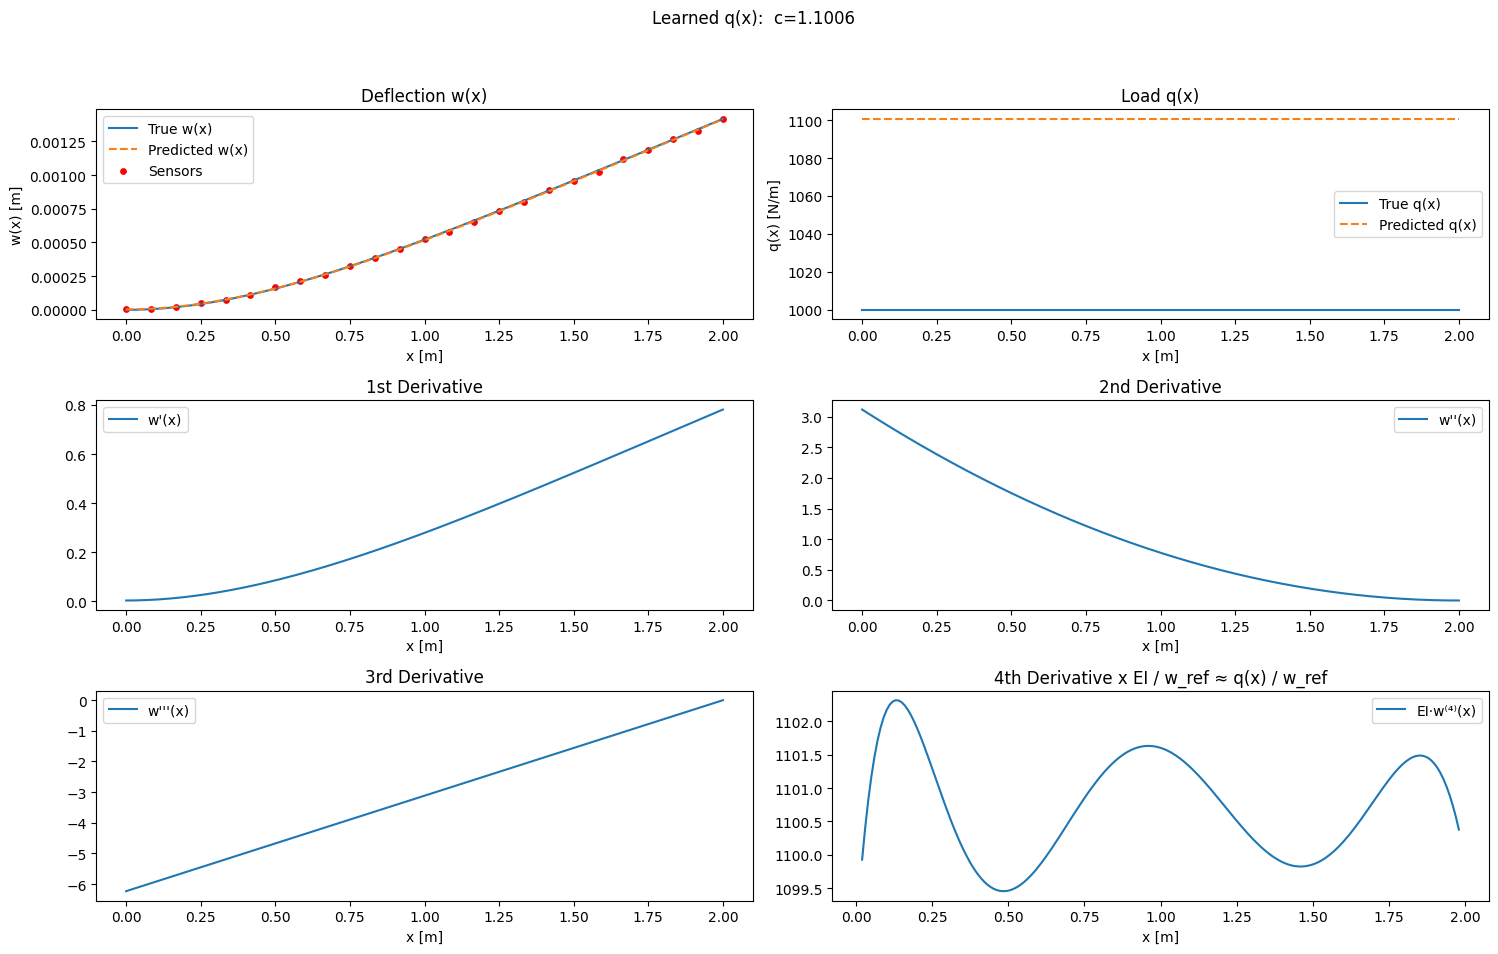

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=1.1006280183792114>

In [266]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 2)

# Define plotting x and evaluate true values
x_plot = x_full  # Dimensional x values
#w_true = w_point_load(x_plot)  # True analytical deflection
q_true = Q * np.ones_like(x_plot)  # Constant uniform load

plt.subplot(gs[0, 0])
plt.plot(x_plot, w_true, label="True w(x)")
plt.plot(x_plot, w_pred, '--', label="Predicted w(x)")
plt.scatter(x_sensors, w_sensors, color='red', label="Sensors", s=15)
plt.title("Deflection w(x)")
plt.xlabel("x [m]")
plt.ylabel("w(x) [m]")
plt.legend()

plt.subplot(gs[0, 1])
plt.plot(x_plot, q_true, label="True q(x)")
plt.plot(x_plot, np.full_like(x_plot, q_pred), '--', label="Predicted q(x)")
plt.title("Load q(x)")
plt.xlabel("x [m]")
plt.ylabel("q(x) [N/m]")
plt.legend()

plt.subplot(gs[1, 0])
plt.plot(x_plot, dw.numpy(), label="w'(x)")
plt.title("1st Derivative")
plt.xlabel("x [m]")
plt.legend()

plt.subplot(gs[1, 1])
plt.plot(x_plot, d2w.numpy(), label="w''(x)")
plt.title("2nd Derivative")
plt.xlabel("x [m]")
plt.legend()

plt.subplot(gs[2, 0])
plt.plot(x_plot, d3w.numpy(), label="w'''(x)")
plt.title("3rd Derivative")
plt.xlabel("x [m]")
plt.legend()

# Ensure w_ref is defined for correct scaling
w_ref = L**4 / EI

plt.subplot(gs[2, 1])
plt.plot(x_plot[2:-2], d4w[2:-2] * w_max / w_ref, label="EI·w⁽⁴⁾(x)")
#plt.plot(x_plot, q_pred , '--', label="Predicted q(x) / w_ref")
plt.title("4th Derivative x EI / w_ref ≈ q(x) / w_ref")
plt.xlabel("x [m]")
plt.legend()
plt.suptitle(f"Learned q(x):  c={q_dim:.4f}")

from sklearn.metrics import r2_score
r2_data = r2_score(w_true, w_pred)
print(f"R² score (PINN Model): {r2_data:.5f}")
#plt.suptitle(f"Learned q(x): a={a_dim:.4f}, b={b_dim:.4f}, c={c_dim:.4f}")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
# Compute R²


q_hat_norm

In [267]:
*_, d4w_cont = compute_derivatives_bc(x_tf)


Text(0.5, 1.0, 'q_hat_norm over epochs')

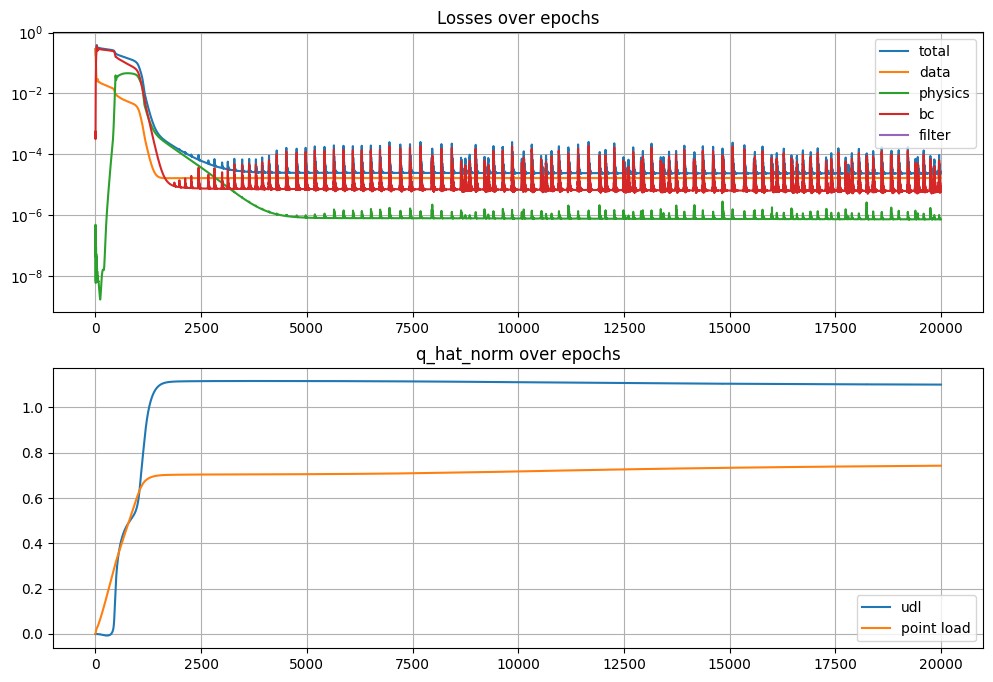

In [268]:
plt.figure(figsize=(12, 8))

plt.subplot(211)
plt.plot(history['loss'], label = 'total')
plt.plot(history['data'], label = 'data')
plt.plot(history['phys'], label = 'physics')
plt.plot(history['bc'], label = 'bc')
plt.plot(history['filter'], label = 'filter')
plt.legend()
plt.grid(True)
plt.title("Losses over epochs")
plt.yscale('log')

plt.subplot(212)
plt.plot(history['q_hat_norm'], label = 'udl')
plt.plot(history['q_pl_norm'], label = 'point load')
plt.legend()
plt.grid(True)
plt.title("q_hat_norm over epochs")

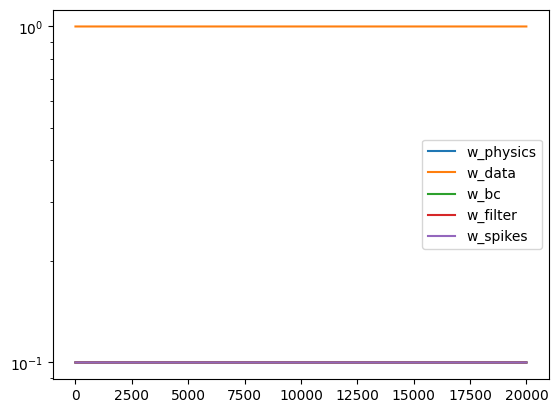

In [269]:
plt.plot(history_weights['w_phys'], label = 'w_physics')
plt.plot(history_weights['w_data'], label = 'w_data')
plt.plot(history_weights['w_bc'], label = 'w_bc')
plt.plot(history_weights['w_filter'], label = 'w_filter')
plt.plot(history_weights['w_spikes'], label = 'w_spikes')

plt.yscale('log')
plt.legend()